南大os主页： http://jyywiki.cn/OS/2023/

jupyter: http://jyywiki.cn/OS/2023/build/lect3.ipynb

In [ ]:
如何写一段代码，直接在硬件运行，how？？
不仅是程序，整个计算机系统也是一个状态机

## 1.OS 启动过程

In [ ]:
free -m 
Firmware 负责加载操作系统
BIOS vs UEFI

os 启动过程：
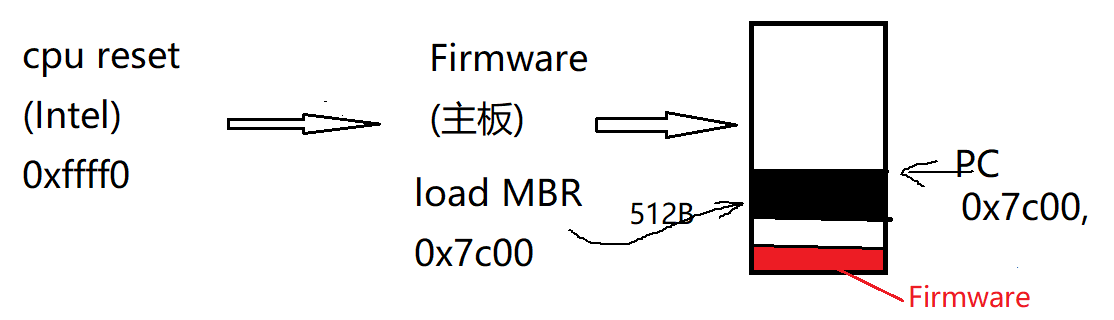



## 2. CPU reset以后每一条指令的执行



In [ ]:
计算机系统公理：你想到的就一定有人做到  
有没有可能去看从CPU reset以后每一条指令的执行？
2种方法：
√  1）模拟方案：QEMU  !!!  
    2) 真机方案：JTAG (Joint Test Action Group) debugger
    一系列 (物理) 调试寄存器，可以实现 gdb 接口 (!!!)


**可引导设备的第一个512字节编译**

In [ ]:
"""
#define SECT_SIZE  512

.code16  // 16-bit assembly

// Entry of the code
.globl _start
_start:
  lea   (msg), %si   // R[si] = &msg;

again:
  movb  (%si), %al   // R[al] = *R[si]; <--+
  incw  %si          // R[si]++;           |
  orb   %al, %al     // if (!R[al])        |
  jz    done         //   goto done; --+   |
  movb  $0x0e, %ah   // R[ah] = 0x0e;  |   |
  movb  $0x00, %bh   // R[bh] = 0x00;  |   |
  int   $0x10        // bios_call();   |   |   // 跳转到 firmware
  jmp   again        // goto again; ---+---+
                     //                |
done:                //                |
  jmp   .            // goto done; <---+

// Data: const char msg[] = "...";
msg:
  .asciz "hello! !!\r\n"

// Magic number for bootable device
.org SECT_SIZE - 2
.byte 0x55, 0xAA

"""

xxd mbr.img | less  # 查看
qemu-system-x86_64 mbr.img  # 运行

**gdb 调试 QEMU**

In [ ]:
$ man qemu-system
 -s     Shorthand for -gdb tcp::1234, i.e. open a gdbserver on TCP port 1234 (see the GDB usage chapter
              in the System Emulation Users Guide).
$ qemu-system-x86_64 -s -S mbr.img &


watch point 使用 !!
wa *0x7c00  

##  3.操作系统就是一个C 程序

In [ ]:
$ make -nB #将命令打印出来，但不执行
$ make -nB | vim -A 